In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from tqdm import tqdm
from PIL import Image
from torchvision.datasets import VOCDetection
from xml.etree.ElementTree import parse as ET_parse
from utils.crowd.synthetic_data import generate_random_conf_matrix, generate_dl_conf_matrix, generate_box_parameters, generate_synthetic_data, xyxy2xywh
from models.rpn_generator import RPNGenerator

In [3]:
class CustomVOCDetection(VOCDetection):
    classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.build_gt()
    
    def build_gt(self):
        # convert to [xmin, ymin, xmax, ymax, class_id]
        targets = []
        for index in range(len(self.annotations)):
            target = self.parse_voc_xml(ET_parse(self.annotations[index]).getroot())['annotation']['object']
            target = [[x['bndbox']['xmin'], x['bndbox']['ymin'], x['bndbox']['xmax'], x['bndbox']['ymax'], self.classes.index(x['name'])]
                      for x in target if x['difficult'] == '0']
            target = [list(map(int, x)) for x in target]
            targets.append(target)
        self.gt = targets
    
    def get_gt(self, index: int):        
        return self.gt[index]

In [4]:
import torchvision.transforms.functional as FT
from torchvision.transforms import ToTensor, ToPILImage, Resize


class StandardTransform:
    def __init__(self, image_size=512, augment=[]):
        self.image_size = image_size
        self.augment = augment
        
    def __call__(self, img, bbox):
        new_image = FT.to_tensor(img)
        new_bbox = torch.FloatTensor(bbox)
        for augment in self.augment:
            new_image, new_bbox = self.augment(new_bbox)
        
        # resize image and box
        dims = (self.image_size, self.image_size)
        new_image = FT.resize(new_image, dims)

        # Resize bounding boxes
        old_dims = torch.FloatTensor([img.width, img.height, img.width, img.height]).unsqueeze(0)
        new_bbox[:, :4] = new_bbox[:, :4] / old_dims  # percent coordinates

        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_bbox[:, :4] = new_bbox[:, :4] * new_dims

        return new_image, new_bbox
    
    
def download_voc_2007(root='../.data/'):
    voc_train = CustomVOCDetection(root=root, year='2007', image_set='trainval', download=True)
    # voc_val = CustomVOCDetection(root=root, year='2007', image_set='val', download=True)
    voc_test = CustomVOCDetection(root=root, year='2007', image_set='test', download=True)
    return voc_train, voc_test
    

In [5]:
voc_train, voc_test = download_voc_2007()

Using downloaded and verified file: ../.data/VOCtrainval_06-Nov-2007.tar
Extracting ../.data/VOCtrainval_06-Nov-2007.tar to ../.data/
Using downloaded and verified file: ../.data/VOCtest_06-Nov-2007.tar
Extracting ../.data/VOCtest_06-Nov-2007.tar to ../.data/


In [6]:
voc_test.get_gt(0)

[[48, 240, 195, 371, 12], [8, 12, 352, 498, 15]]

In [7]:
len(voc_train), len(voc_test)

(5011, 4952)

In [8]:
reliability_level = 0.6
n_classes=5
alpha = (reliability_level - (1 - reliability_level) / (n_classes - 1)) * np.eye(n_classes) + \
        (1 - reliability_level) / (n_classes - 1)

In [9]:
alpha

array([[        0.6,         0.1,         0.1,         0.1,         0.1],
       [        0.1,         0.6,         0.1,         0.1,         0.1],
       [        0.1,         0.1,         0.6,         0.1,         0.1],
       [        0.1,         0.1,         0.1,         0.6,         0.1],
       [        0.1,         0.1,         0.1,         0.1,         0.6]])

In [10]:
np.mean([np.random.dirichlet(alpha[0, :]) for _ in range(100)], 0)

array([    0.60481,     0.11913,    0.088117,    0.075057,     0.11288])

In [11]:
coco_classes = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
voc_classes = ['background', 'airplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'dining table', 'dog', 'horse',
               'motorcycle', 'person', 'potted plant',
               'sheep', 'couch', 'train', 'tv']

In [12]:
coco2voc_classes = [coco_classes.index(c) for c in voc_classes]

In [13]:
alexnet_cm = np.load('../outputs/classification-coco/alexnet_scratch/conf_matrix.npy')[coco2voc_classes][:, coco2voc_classes] + 1
vgg16_cm = np.load('../outputs/classification-coco/vgg16_scratch/conf_matrix.npy')[coco2voc_classes][:, coco2voc_classes] + 1
resnet50_cm = np.load('../outputs/classification-coco/resnet50_scratch/conf_matrix.npy')[coco2voc_classes][:, coco2voc_classes] + 1

In [14]:
conf_matrix = generate_random_conf_matrix(3, 5, acc_mean=[0.9] + [0.6] * 4)
conf_matrix

array([[[    0.81981,    0.012956,    0.026524,    0.034946,     0.10577],
        [   0.048029,      0.6032,    0.080338,      0.1111,     0.15733],
        [    0.10684,     0.08348,     0.63704,    0.081623,     0.09101],
        [   0.065945,    0.050939,     0.25768,     0.60763,    0.017804],
        [     0.1204,     0.11821,     0.10761,    0.010591,     0.64319]],

       [[    0.84213,    0.046073,    0.022825,    0.039489,    0.049484],
        [    0.02471,     0.63481,     0.15976,    0.029356,     0.15136],
        [   0.019954,     0.10753,     0.61757,     0.19039,    0.064549],
        [     0.1113,     0.12504,     0.10779,     0.59838,    0.057485],
        [    0.12624,     0.16446,    0.031408,    0.077236,     0.60066]],

       [[    0.92565,    0.023009,    0.014462,    0.014009,    0.022865],
        [    0.10431,     0.67185,    0.035789,     0.08942,    0.098629],
        [      0.179,    0.005011,     0.58891,     0.10343,     0.12365],
        [    0.04575,

In [15]:
a = np.cumsum(conf_matrix[0, [3, 4], :], axis=1)
a

array([[   0.065945,     0.11688,     0.37457,      0.9822,           1],
       [     0.1204,     0.23862,     0.34622,     0.35681,           1]])

In [16]:
b = np.random.default_rng().random((len([3, 4]), 1))
b

array([[    0.89835],
       [    0.74561]])

In [17]:
np.sum(a < b, axis=1)

array([3, 4])

In [18]:
np.sum(np.cumsum(conf_matrix[0, [3, 4], :], axis=1) < np.random.default_rng().random((len([3, 4]), 1)), axis=1)

array([3, 1])

In [19]:
np.random.default_rng().random(len([3, 4]))

array([    0.15272,     0.55964])

In [20]:
conf_matrix = generate_dl_conf_matrix(3, vgg16_cm)
conf_matrix

array([[[    0.84788,    0.042183,   0.0073231, ...,   0.0038308,    0.015207,   0.0072456],
        [  0.0055156,     0.93198,   0.0012805, ...,  0.00059832,     0.01047,  0.00086712],
        [  0.0018287,   0.0071938,     0.70845, ...,    0.001614,   0.0050926,  0.00031646],
        ...,
        [  0.0084103,    0.038409,   0.0054829, ...,     0.73585,    0.011232,   0.0045508],
        [  0.0029566,    0.027894,   0.0013326, ...,   0.0015757,     0.90072,   0.0013997],
        [  0.0063693,    0.010958,  0.00042006, ...,   0.0030723,   0.0033739,     0.95562]],

       [[    0.84338,    0.037265,   0.0034344, ...,   0.0038736,     0.01439,   0.0074154],
        [  0.0044758,     0.93037,  0.00044365, ...,  0.00018366,    0.010377,   0.0012045],
        [  0.0028651,   0.0081001,     0.71539, ...,   0.0012416,    0.002466,  5.4244e-05],
        ...,
        [  0.0078033,    0.034995,   0.0027227, ...,      0.7419,   0.0080202,   0.0054831],
        [  0.0020979,    0.026019,  0.0006

In [21]:
conf_matrix.sum(axis=2)

array([[          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1],
       [          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1],
       [          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1]])

In [22]:
generate_box_parameters(5)

array([[[    0.04767,    0.015955],
        [   -0.01198,   0.0059046],
        [   0.042325,    0.012088],
        [  -0.023831,    0.015927]],

       [[   0.046408,    0.043181],
        [  -0.023635,    0.043188],
        [ -0.0058994,    0.033744],
        [   0.010987,    0.032994]],

       [[   0.023576,   0.0030069],
        [  -0.027725,    0.034184],
        [  -0.032793,    0.033562],
        [   0.037041,    0.030551]],

       [[  -0.043986,  0.00015661],
        [   0.047777,    0.012563],
        [ -0.0061048,    0.042925],
        [  0.0032595,    0.021265]],

       [[   0.023582,   0.0091166],
        [   0.042204,    0.047006],
        [  -0.034653,   0.0043442],
        [   0.049226,    0.023411]]])

In [23]:
dataloader = torch.utils.data.DataLoader(voc_train, shuffle=False, batch_size=16, collate_fn=lambda x: x)
device = torch.device('cuda')

In [24]:
# rpn proposals
resnet18_weight = '../outputs/rpn-coco/resnet18/weights/epoch_004.pt'
resnet50_weight = '../outputs/rpn-coco/resnet50/weights/epoch_004.pt'
resnet101_weight = '../outputs/rpn-coco/resnet101/weights/epoch_004.pt'
resnet18_proposals, resnet50_proposals, resnet101_proposals = [], [], []

with torch.no_grad():
    for weight, results in zip([resnet18_weight, resnet50_weight, resnet101_weight], [resnet18_proposals, resnet50_proposals, resnet101_proposals]):
        model = torch.load(weight)['model']
        model.rpn.nms_thresh = 0.9
        model.eval()
        model.to(device)
        for data in tqdm(dataloader, total=len(dataloader)):
            imgs = list(FT.to_tensor(x[0]).to(device) for x in data)
            proposals, scores, _ = model(imgs)
            for proposal, score in zip(proposals, scores):
                results.append(np.concatenate([proposal.cpu().numpy(), np.expand_dims(score.cpu().numpy(), -1)], -1))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314/314 [06:17<00:00,  1.20s/it]


In [25]:
resnet50_proposals[0].shape

(1000, 5)

In [26]:
conf_matrix = generate_dl_conf_matrix(10, vgg16_cm)
# crowd_labels, conf_matrix, box_params = generate_synthetic_data(voc_test, n_annotator=10, conf_matrix=conf_matrix, fixed_box=False,
#                                                                 translation_err_mean=(0.1, 0.1), translation_err_std=(0.01, 0.01), 
#                                                                 scale_err_mean=(0.3, 0.3), scale_err_std=(0.05, 0.05))
rpn_proposals = {i: resnet50_proposals for i in range(10)}
crowd_labels, conf_matrix, box_params = generate_synthetic_data(voc_train, n_annotator=10, conf_matrix=conf_matrix, fixed_box=False, fp_prob=0.,
                                                                rpn_proposals=rpn_proposals)

In [27]:
conf_matrix[0][0]*100

array([     84.788,      4.2183,     0.73231,     0.56012,        1.01,    0.058014,     0.27175,     0.07961,     0.12961,     0.41845,     0.31346,     0.22405,     0.34387,     0.21169,     0.45672,     0.26973,      2.9448,     0.34151,     0.38308,      1.5207,     0.72456])

In [28]:
box_params

array([[[    0.09534,     0.03191],
        [  -0.023961,    0.011809],
        [   0.084649,    0.024177],
        [  -0.047662,    0.031853]],

       [[   0.092816,    0.086362],
        [   -0.04727,    0.086376],
        [  -0.011799,    0.067488],
        [   0.021974,    0.065987]],

       [[   0.047152,   0.0060139],
        [  -0.055449,    0.068369],
        [  -0.065587,    0.067124],
        [   0.074083,    0.061102]],

       [[  -0.087973,  0.00031323],
        [   0.095554,    0.025127],
        [   -0.01221,    0.085849],
        [   0.006519,     0.04253]],

       [[   0.047164,    0.018233],
        [   0.084409,    0.094011],
        [  -0.069305,   0.0086883],
        [   0.098452,    0.046821]],

       [[   0.065798,    0.084171],
        [   -0.04379,    0.044887],
        [   0.073818,    0.037051],
        [   0.095283,    0.048267]],

       [[  -0.081564,    0.044891],
        [  -0.054663,     0.03055],
        [  0.0073132,    0.094736],
        [   0.04

In [29]:
import cv2
import matplotlib.pyplot as plt
import bbox_visualizer as bbv

#visualization

[[52, 166, 167, 332]]

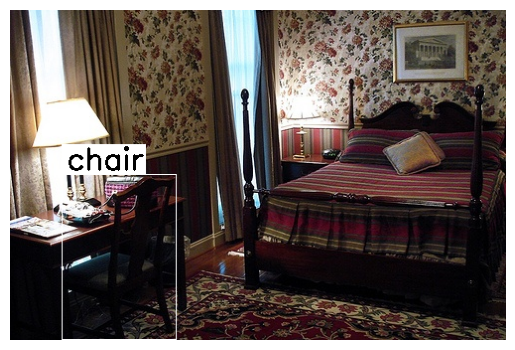

In [30]:
i = 100
img_path = voc_train.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

bboxes = [x[:4] for x in voc_train.get_gt(i)]
labels = [voc_train.classes[x[4]] for x in voc_train.get_gt(i)]
for box, label in zip(bboxes, labels):
    img = bbv.draw_rectangle(img, box, thickness=1)
    img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
bboxes

[[[22, 186, 133, 299, 18]], [[51, 165, 166, 331, 15]], [[0, 199, 262, 333, 11]], [[0, 194, 243, 333, 19]], [[51, 165, 166, 331, 2]]]


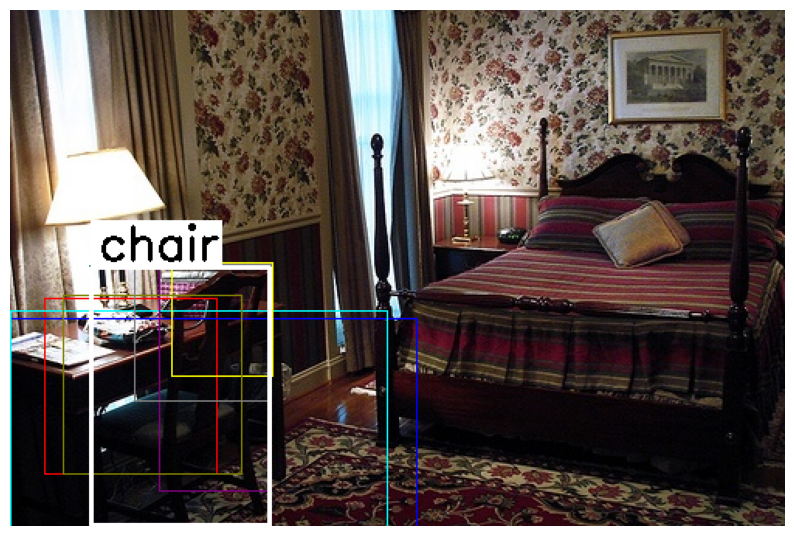

In [31]:
plt.figure(figsize=(10, 8))
img_path = voc_train.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# plot 3 annotator
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
bboxes = [[x[:4] for x in y] for y in crowd_labels[i][:10]]
labels = [[voc_train.classes[x[4]] for x in y] for y in crowd_labels[i][:10]]

for color, box, label in zip(colors, bboxes, labels):
    img = bbv.draw_multiple_rectangles(img, box, color, thickness=1)
    # img = bbv.add_multiple_labels(img, label, box, color)
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

bboxes = [x[:4] for x in voc_train.get_gt(i)]
labels = [voc_train.classes[x[4]] for x in voc_train.get_gt(i)]
for box, label in zip(bboxes, labels):
    img = bbv.draw_rectangle(img, box, thickness=2)
    img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
# plt.savefig('./example_crowd2.png')
print(crowd_labels[i][:5])

In [32]:
crowd_labels[i]

[[[22, 186, 133, 299, 18]],
 [[51, 165, 166, 331, 15]],
 [[0, 199, 262, 333, 11]],
 [[0, 194, 243, 333, 19]],
 [[51, 165, 166, 331, 2]],
 [[104, 163, 169, 236, 9]],
 [[51, 165, 166, 331, 17]],
 [[96, 164, 168, 310, 3]],
 [[34, 184, 149, 299, 20]],
 [[80, 164, 168, 252, 9]]]

# SIM

In [33]:
# create synthetic train dataset

import os
import pandas as pd

def crowd_labels2df(crowd_labels, dataset):
    temp_data = []
    for crowd_label, img_file in zip(crowd_labels, dataset.images):
        img_file = os.path.basename(img_file)
        for ann_id, annotations in enumerate(crowd_label):
            for box in annotations:
                temp_data.append([img_file, *box, ann_id])

    df = pd.DataFrame(temp_data, columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_id', 'annotator_id'])
    df['class_id'] = df['class_id'] - 1
    # for x in ['x1', 'y1', 'x2', 'y2']:
    #     df[x] = df[x] - 1
    return df

def crowd_labels_df2txt(df, path='../data/voc2007'):
    os.makedirs(path, exist_ok=True)
    for filename, group in df.groupby('img_path'):
        filename += '.txt'
        group.drop(columns='img_path').to_csv(os.path.join(path, filename), index=False, header=False)


In [30]:
conf_matrix = generate_dl_conf_matrix(5, vgg16_cm)
crowd_labels, conf_matrix, box_params = generate_synthetic_data(voc_train, n_annotator=5, conf_matrix=conf_matrix, fixed_box=True)
df = crowd_labels2df(crowd_labels, voc_train)

In [31]:
box_params

In [32]:
# save_path = '../data/voc2007_ann10_full'
save_path = '../data/voc2007_ann5_sim'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [33]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000005.jpg,262,210,323,338,19,0
1,000005.jpg,164,263,252,371,8,0
2,000005.jpg,240,193,294,298,17,0
3,000005.jpg,262,210,323,338,2,1
4,000005.jpg,164,263,252,371,8,1
...,...,...,...,...,...,...,...
64525,009961.jpg,68,3,391,344,12,0
64526,009961.jpg,68,3,391,344,11,1
64527,009961.jpg,68,3,391,344,11,2
64528,009961.jpg,68,3,391,344,14,3


In [35]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [36]:
# create valtest dataset

In [34]:
def clean2df(dataset):
    temp_data = []
    for gt, img_file in zip(dataset.gt, dataset.images):
        img_file = os.path.basename(img_file)
        # print(gt)
        for box in gt:
            temp_data.append([img_file, *box])

    df = pd.DataFrame(temp_data, columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_id'])
    df['class_id'] = df['class_id'] - 1
    for x in ['x1', 'y1', 'x2', 'y2']:
        df[x] = df[x] - 1
    return df


In [38]:
train_clean_df = clean2df(voc_train)

In [39]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000005.jpg,262,210,323,338,8
1,000005.jpg,164,263,252,371,8
2,000005.jpg,240,193,294,298,8
3,000007.jpg,140,49,499,329,6
4,000009.jpg,68,171,269,329,12
...,...,...,...,...,...,...
12603,009958.jpg,88,26,148,216,14
12604,009958.jpg,74,38,146,123,14
12605,009958.jpg,76,120,177,315,1
12606,009959.jpg,191,141,329,186,6


In [40]:
crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [41]:
test_df = clean2df(voc_test)

In [42]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000001.jpg,47,239,194,370,11
1,000001.jpg,7,11,351,497,14
2,000002.jpg,138,199,206,300,18
3,000003.jpg,122,154,214,194,17
4,000003.jpg,238,155,306,204,8
...,...,...,...,...,...,...
12027,009962.jpg,210,191,323,325,8
12028,009962.jpg,161,71,272,247,14
12029,009962.jpg,249,67,472,311,14
12030,009962.jpg,3,1,252,373,14


In [43]:
crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))

# FULL

In [36]:
conf_matrix = generate_dl_conf_matrix(10, vgg16_cm)
rpn_proposals = {i: resnet50_proposals for i in range(10)}
crowd_labels, conf_matrix, box_params = generate_synthetic_data(voc_train, n_annotator=10, conf_matrix=conf_matrix, fixed_box=False,
                                                                rpn_proposals=rpn_proposals)
                                                                # translation_err_mean=(0.1, 0.1), translation_err_std=(0.01, 0.01), 
                                                                # scale_err_mean=(0.3, 0.3), scale_err_std=(0.05, 0.05))
df = crowd_labels2df(crowd_labels, voc_train)

In [37]:
save_path = '../data/voc2007_ann10_full'
# save_path = '../data/voc2007_ann5_0.7'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [38]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000005.jpg,231,221,330,342,19,0
1,000005.jpg,100,250,216,360,8,0
2,000005.jpg,238,231,303,320,17,0
3,000005.jpg,262,210,323,338,19,1
4,000005.jpg,164,263,252,371,8,1
...,...,...,...,...,...,...,...
125342,009961.jpg,55,97,500,353,11,5
125343,009961.jpg,68,3,391,344,7,6
125344,009961.jpg,68,3,391,344,11,7
125345,009961.jpg,68,3,391,344,14,8


In [39]:
df[['x1', 'y1', 'x2', 'y2']].min()

x1    0
y1    0
x2    7
y2    8
dtype: int64

In [40]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [41]:
# create valtest dataset

In [42]:
train_clean_df = clean2df(voc_train)

In [43]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000005.jpg,262,210,323,338,8
1,000005.jpg,164,263,252,371,8
2,000005.jpg,240,193,294,298,8
3,000007.jpg,140,49,499,329,6
4,000009.jpg,68,171,269,329,12
...,...,...,...,...,...,...
12603,009958.jpg,88,26,148,216,14
12604,009958.jpg,74,38,146,123,14
12605,009958.jpg,76,120,177,315,1
12606,009959.jpg,191,141,329,186,6


In [44]:
crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [45]:
test_df = clean2df(voc_test)

In [46]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000001.jpg,47,239,194,370,11
1,000001.jpg,7,11,351,497,14
2,000002.jpg,138,199,206,300,18
3,000003.jpg,122,154,214,194,17
4,000003.jpg,238,155,306,204,8
...,...,...,...,...,...,...
12027,009962.jpg,210,191,323,325,8
12028,009962.jpg,161,71,272,247,14
12029,009962.jpg,249,67,472,311,14
12030,009962.jpg,3,1,252,373,14


In [47]:
crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))

# MIX

In [49]:
seed = 1234
n_classes = len(voc_train.classes)
# expert
exp_conf_matrix = generate_dl_conf_matrix(5, resnet50_cm, seed=seed)
exp_box_params = generate_box_parameters(5, translation_err_mean=(0.1, 0.1), translation_err_std=(0.01, 0.01), 
                                     scale_err_mean=(0.3, 0.3), scale_err_std=(0.05, 0.05), seed=seed)
# normal
norm_conf_matrix = generate_dl_conf_matrix(20, vgg16_cm, seed=seed+1)
norm_box_params = generate_box_parameters(20, translation_err_mean=(0.2, 0.2), translation_err_std=(0.05, 0.05), 
                                     scale_err_mean=(0.4, 0.4), scale_err_std=(0.1, 0.1), seed=seed+1)

conf_matrix = np.concatenate((exp_conf_matrix, norm_conf_matrix), axis=0)
box_params = np.concatenate((exp_box_params, norm_box_params), axis=0)

In [50]:
rpn_proposals = {}
for i in range(5):
    rpn_proposals[i] = resnet101_proposals
for i in range(5, 25):
    rpn_proposals[i] = resnet50_proposals
assert len(rpn_proposals) == conf_matrix.shape[0]

In [51]:
conf_matrix.shape, box_params.shape

((25, 21, 21), (25, 4, 2))

<Axes: >

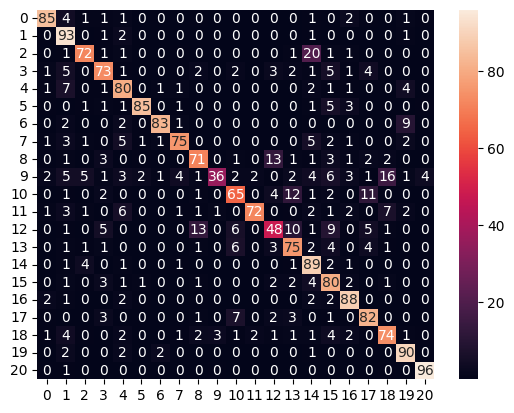

In [52]:
sns.heatmap(conf_matrix[15] * 100, annot=True, fmt='.0f')

In [53]:
save_path = '../data/voc2007_ann25_mix'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [54]:
crowd_labels, conf_matrix, box_params = generate_synthetic_data(voc_train, conf_matrix=conf_matrix, rpn_proposals=rpn_proposals, fixed_box=False)

[[[16, 134, 125, 310, 16], [59, 24, 251, 291, 16], [136, 91, 280, 351, 16], [376, 128, 487, 323, 16], [109, 0, 500, 301, 16]], [[7, 88, 123, 309, 16], [128, 172, 258, 364, 16], [170, 147, 316, 298, 16], [349, 148, 439, 329, 2], [275, 184, 363, 280, 16]], [[7, 88, 123, 309, 16], [113, 202, 270, 310, 16], [131, 231, 309, 337, 16], [310, 2, 499, 330, 16], [269, 122, 366, 297, 16]], [[7, 88, 123, 309, 16], [141, 167, 262, 353, 16], [136, 91, 280, 351, 16], [310, 2, 499, 330, 16], [100, 42, 423, 339, 16]], [[7, 88, 123, 309, 16], [0, 0, 292, 279, 16], [136, 91, 280, 351, 16], [336, 135, 482, 285, 16], [246, 2, 394, 293, 16]]]


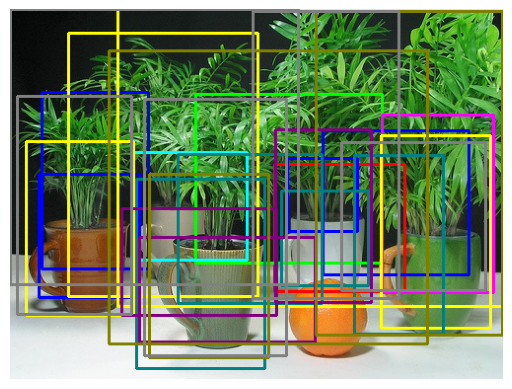

In [55]:
i=993
img_path = voc_train.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# plot 3 annotator
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
bboxes = [[x[:4] for x in y] for y in crowd_labels[i][:10]]
labels = [[voc_train.classes[x[4]] for x in y] for y in crowd_labels[i][:10]]

for color, box, label in zip(colors, bboxes, labels):
    img = bbv.draw_multiple_rectangles(img, box, color, thickness=2)
    # img = bbv.add_multiple_labels(img, label, box, color)
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

# bboxes = [x[:4] for x in voc_train.get_gt(i)]
# labels = [voc_train.classes[x[4]] for x in voc_train.get_gt(i)]
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
print(crowd_labels[i][5:10])

In [56]:
img_path

'../.data/VOCdevkit/VOC2007/JPEGImages/002015.jpg'

In [57]:
df = crowd_labels2df(crowd_labels, voc_train)

In [58]:
df[['x1', 'y1', 'x2', 'y2']].min()

x1    0
y1    0
x2    6
y2    8
dtype: int64

In [59]:
df[(df['x1'] > df['x2']) | (df['y1'] > df['y2'])]

,img_path,x1,y1,x2,y2,class_id,annotator_id


In [60]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000005.jpg,241,207,308,291,17,0
1,000005.jpg,168,246,234,316,8,0
2,000005.jpg,231,202,309,310,17,0
3,000005.jpg,262,210,323,338,17,1
4,000005.jpg,164,263,252,371,8,1
...,...,...,...,...,...,...,...
313549,009961.jpg,20,6,227,374,11,20
313550,009961.jpg,177,106,314,289,7,21
313551,009961.jpg,68,3,391,344,14,22
313552,009961.jpg,245,111,500,343,11,23


In [61]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [62]:
# create valtest dataset

In [63]:
train_clean_df = clean2df(voc_train)

In [64]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000005.jpg,262,210,323,338,8
1,000005.jpg,164,263,252,371,8
2,000005.jpg,240,193,294,298,8
3,000007.jpg,140,49,499,329,6
4,000009.jpg,68,171,269,329,12
...,...,...,...,...,...,...
12603,009958.jpg,88,26,148,216,14
12604,009958.jpg,74,38,146,123,14
12605,009958.jpg,76,120,177,315,1
12606,009959.jpg,191,141,329,186,6


In [65]:
crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [66]:
test_df = clean2df(voc_test)

In [67]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000001.jpg,47,239,194,370,11
1,000001.jpg,7,11,351,497,14
2,000002.jpg,138,199,206,300,18
3,000003.jpg,122,154,214,194,17
4,000003.jpg,238,155,306,204,8
...,...,...,...,...,...,...
12027,009962.jpg,210,191,323,325,8
12028,009962.jpg,161,71,272,247,14
12029,009962.jpg,249,67,472,311,14
12030,009962.jpg,3,1,252,373,14


In [68]:
crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))